# Author Identification: LSM (Language Style Matching)

## 1) Prepare data

In [2]:
import pandas as pd
import numpy as np

author_info = pd.read_json('fanfic-data/author.json')
author_info

,author
0,IMP
1,MIX
2,SMC
3,AVO


In [3]:
X = []
y = []

In [4]:
## alternative way:
# fictions from fandom "Inception" as training set
X_train_inc = []
y_train_inc = []

# others as test set
X_test_inc = []
y_test_inc = []

In [5]:
# read text files from all authors
for auth in author_info['author']:
    
    info = pd.read_json('fanfic-data/'+auth+'/info.json')
    
    text_file = []
    ind_inception = [] ##
    
    for index, row in info.iterrows():
        # read individual file
        file = row['snippet']
        auth = row['author']
        df = pd.read_csv('fanfic-data/'+auth+'/'+file+'.txt', sep='/n', \
                         header=None, engine='python', encoding='utf-8')
        text_file.append(df[0]) # default column '0', rows of snippets
        ind_inception.append([row['fandom'] == 'inception' \
                              for i in range(len(df[0]))]) ##
        
    text = np.hstack(text_file)
    X.append(text)
    y.append(np.repeat(auth, text.size))
    
    is_inc = np.hstack(ind_inception)
    X_train_inc.append(text[is_inc])
    y_train_inc.append(np.repeat(auth, text[is_inc].size))
    X_test_inc.append(text[~is_inc])
    y_test_inc.append(np.repeat(auth, text[~is_inc].size))

#### check sample size from each class:

In [6]:
for X_i in X:
    print(len(X_i))

248
218
235
150


In [7]:
for y_i in y:
    print(len(y_i))

248
218
235
150


#### feature matrix and class label

In [8]:
X = np.hstack(X)
y = np.hstack(y)

In [9]:
print(X.size)

851


In [10]:
X_train_inc = np.hstack(X_train_inc)
y_train_inc = np.hstack(y_train_inc)
X_test_inc = np.hstack(X_test_inc)
y_test_inc = np.hstack(y_test_inc)

In [11]:
print(X_train_inc.size)
print(y_train_inc.size)
print(X_test_inc.size)
print(y_test_inc.size)

499
499
352
352


#### label encoding

In [12]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [13]:
y_train_inc = labelencoder.fit_transform(y_train_inc)
y_test_inc = labelencoder.fit_transform(y_test_inc)

## 2) Text preprocessing: tokenizer

In [14]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [15]:
# define LSM: POS of choice
list_of_pos = ['ADP','ADV','AUX','CCONJ','DET','INTJ','PART','PRON','SCONJ','PUNCT']

def LSM_tokenizer(document):
    tokens = nlp(document)
    tokens = [token.lemma_ for token in tokens if (
        token.pos_ in list_of_pos and token.lemma_.strip() != '')]
    return tokens

In [16]:
# define stopword removal
def SR_tokenizer(document):
    tokens = nlp(document)
    tokens = [token.lemma_ for token in tokens if (
        token.is_stop == False and \
        token.is_punct == False and \
        token.lemma_.strip()!= '')]
    return tokens

## 3) Feature engineering (extraction)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [18]:
# split dataset: 80% train, 20% validation
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 1234,
                                                    stratify = y)

In [19]:
bow_transformer = CountVectorizer(tokenizer = LSM_tokenizer).fit(X_train)

tfidf_transformer = TfidfVectorizer(tokenizer = LSM_tokenizer).fit(X_train)

C:\Users\zhan\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [20]:
# print(bow_transformer.get_feature_names()[:20])
# print(tfidf_transformer.get_feature_names()[:20])

In [21]:
# transform into bag-of-words OR tf-idf
text_bow_train = bow_transformer.transform(X_train)
text_bow_test = bow_transformer.transform(X_test)

text_tfidf_train = tfidf_transformer.transform(X_train)
text_tfidf_test = tfidf_transformer.transform(X_test)

## 4) Model selection

### i. Multinomial Naive Bayes
Note: Naive Bayes doesn't have any hyperparameters to tune

#### train MultinomialNB & perform k-fold CV (k=10)

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

mnb = MultinomialNB()
cv_acc1 = cross_val_score(estimator=mnb,
                         X=text_bow_train,
                         y=y_train,
                         cv=10)

cv_acc2 = cross_val_score(estimator=mnb,
                         X=text_tfidf_train,
                         y=y_train,
                         cv=10)

model1 = MultinomialNB().fit(text_bow_train, y_train)
model2 = MultinomialNB().fit(text_tfidf_train, y_train)

print('Multinomial Naive Bayes classifier:')
print('1) BOW')
print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc1)*100))
print('Test Accuracy: %.2f%%' % (model1.score(text_bow_test, y_test)*100))
print('2) Tf-idf')
print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc2)*100))
print('Test Accuracy: %.2f%%' % (model2.score(text_tfidf_test, y_test)*100))

Multinomial Naive Bayes classifier:
1) BOW
Kfold Accuracy: 92.50%
Test Accuracy: 92.98%
2) Tf-idf
Kfold Accuracy: 55.44%
Test Accuracy: 55.56%


#### Precision, Recall, F1-score

In [23]:
from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, f1_score, matthews_corrcoef

def display_scores(y_test, y_pred):
    print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='macro'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='macro'))
    print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='macro'))
    print('MCC: %.3f' % matthews_corrcoef(y_true=y_test, y_pred=y_pred))

In [24]:
predictions1 = model1.predict(text_bow_test)
print('1) BOW')
display_scores(y_test, predictions1)


predictions2 = model2.predict(text_tfidf_test)
print('2) Tf-idf')
display_scores(y_test, predictions2)

1) BOW
Accuracy: 0.930
Precision: 0.932
Recall: 0.924
F1: 0.927
MCC: 0.906
2) Tf-idf
Accuracy: 0.556
Precision: 0.278
Recall: 0.490
F1: 0.355
MCC: 0.446


C:\Users\zhan\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Confusion matrix

In [25]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import matplotlib.pyplot as plt

# define a module for confusion matirx
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.86666667 0.1        0.03333333 0.        ]
 [0.04       0.94       0.         0.02      ]
 [0.         0.04545455 0.90909091 0.04545455]
 [0.         0.0212766  0.         0.9787234 ]]
Normalized confusion matrix
[[0.         0.76666667 0.         0.23333333]
 [0.         0.96       0.         0.04      ]
 [0.         0.40909091 0.         0.59090909]
 [0.         0.         0.         1.        ]]


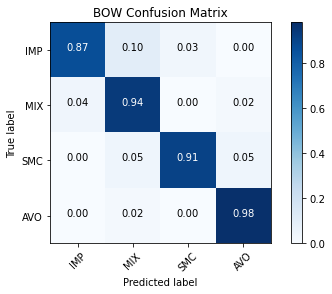

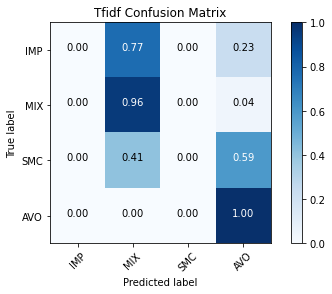

In [26]:
cm1 = confusion_matrix(y_test,predictions1)
plt.figure()

plot_confusion_matrix(cm1, author_info['author'], normalize=True, title='BOW Confusion Matrix')

cm2 = confusion_matrix(y_test,predictions2)
plt.figure()

plot_confusion_matrix(cm2, author_info['author'], normalize=True, title='Tfidf Confusion Matrix')

#### balanced accuracy

In [27]:
from mlxtend.evaluate import accuracy_score
avg_acc = accuracy_score(y_test, predictions1, method='average')
print(f'Average per-class accuracy: {avg_acc*100:.2f}%')

Average per-class accuracy: 96.49%


### ii. KNN (baseline)

#### train KNN & perform grid search CV

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

grid_params = {
    'n_neighbors': [3,5,7,9,11,13,15,17,19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

gs = GridSearchCV(estimator=KNeighborsClassifier(),
                  param_grid=grid_params,
                  cv=10)

gs.fit(text_bow_train, y_train)
model1 = gs.best_estimator_
print('1) BOW')
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

gs.fit(text_tfidf_train, y_train)
model2 = gs.best_estimator_
print('2) Tf-idf')
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

1) BOW
Best Accuracy: 76.18%
Best Params: {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'uniform'}
2) Tf-idf
Best Accuracy: 73.09%
Best Params: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}


#### Precision, Recall, F1-score

In [28]:
predictions1 = model1.predict(text_bow_test)
print('1) BOW')
display_scores(y_test, predictions1)


predictions2 = model2.predict(text_tfidf_test)
print('2) Tf-idf')
display_scores(y_test, predictions2)

1) BOW
Accuracy: 0.725
Precision: 0.739
Recall: 0.706
F1: 0.708
MCC: 0.638
2) Tf-idf
Accuracy: 0.760
Precision: 0.787
Recall: 0.755
F1: 0.748
MCC: 0.693


#### Confusion matrix

Normalized confusion matrix
[[0.53333333 0.26666667 0.06666667 0.13333333]
 [0.1        0.72       0.04       0.14      ]
 [0.04545455 0.02272727 0.61363636 0.31818182]
 [0.         0.         0.04255319 0.95744681]]
Normalized confusion matrix
[[0.76666667 0.1        0.06666667 0.06666667]
 [0.08       0.8        0.04       0.08      ]
 [0.04545455 0.06818182 0.45454545 0.43181818]
 [0.         0.         0.         1.        ]]


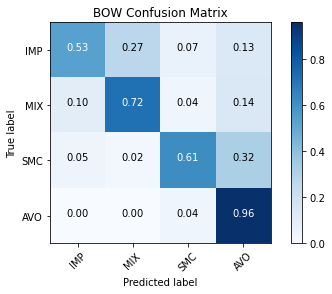

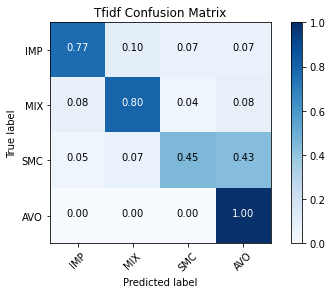

In [29]:
cm1 = confusion_matrix(y_test,predictions1)
plt.figure()

plot_confusion_matrix(cm1, author_info['author'], normalize=True, title='BOW Confusion Matrix')

cm2 = confusion_matrix(y_test,predictions2)
plt.figure()

plot_confusion_matrix(cm2, author_info['author'], normalize=True, title='Tfidf Confusion Matrix')

### iii. Random Forest

#### train Random Forest & perform grid search CV

In [30]:
from sklearn.ensemble import RandomForestClassifier

grid_params = {'min_samples_split': [2, 3, 4, 5, 6, 7],
               'max_features': ['auto', 'sqrt']}

gs = GridSearchCV(estimator=RandomForestClassifier(random_state=123),
                  param_grid=grid_params,
                  cv=10)

gs.fit(text_bow_train, y_train)
model1 = gs.best_estimator_
print('1) BOW')
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

gs.fit(text_tfidf_train, y_train)
model2 = gs.best_estimator_
print('2) Tf-idf')
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

1) BOW
Best Accuracy: 86.03%
Best Params: {'max_features': 'auto', 'min_samples_split': 6}
2) Tf-idf
Best Accuracy: 86.47%
Best Params: {'max_features': 'auto', 'min_samples_split': 2}


#### Precision, Recall, F1-score

In [31]:
predictions1 = model1.predict(text_bow_test)
print('1) BOW')
display_scores(y_test, predictions1)


predictions2 = model2.predict(text_tfidf_test)
print('2) Tf-idf')
display_scores(y_test, predictions2)

1) BOW
Accuracy: 0.877
Precision: 0.897
Recall: 0.857
F1: 0.868
MCC: 0.836
2) Tf-idf
Accuracy: 0.871
Precision: 0.885
Recall: 0.846
F1: 0.854
MCC: 0.829


#### Confusion matrix

Normalized confusion matrix
[[0.66666667 0.16666667 0.13333333 0.03333333]
 [0.         0.94       0.         0.06      ]
 [0.         0.04545455 0.88636364 0.06818182]
 [0.         0.04255319 0.0212766  0.93617021]]
Normalized confusion matrix
[[0.6        0.23333333 0.16666667 0.        ]
 [0.         0.96       0.         0.04      ]
 [0.02272727 0.04545455 0.88636364 0.04545455]
 [0.         0.0212766  0.04255319 0.93617021]]


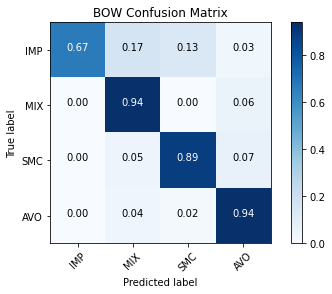

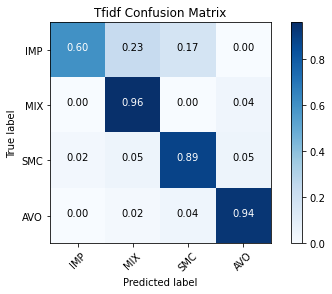

In [32]:
cm1 = confusion_matrix(y_test,predictions1)
plt.figure()

plot_confusion_matrix(cm1, author_info['author'], normalize=True, title='BOW Confusion Matrix')

cm2 = confusion_matrix(y_test,predictions2)
plt.figure()

plot_confusion_matrix(cm2, author_info['author'], normalize=True, title='Tfidf Confusion Matrix')

### iv. XGBoost

#### train XGBoost & perform grid search CV

In [34]:
from xgboost import XGBClassifier
# 'max_depth': range (2, 10, 1),
               
grid_params = {'max_depth': [2, 5, 10],
               'learning_rate': [0.1, 0.05]}

gs = GridSearchCV(estimator=XGBClassifier(random_state=123, 
                                          use_label_encoder=False, 
                                          eval_metric='merror'),
                  param_grid=grid_params,
                  cv=10)

gs.fit(text_bow_train, y_train)
model1 = gs.best_estimator_
print('1) BOW')
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

gs.fit(text_tfidf_train, y_train)
model2 = gs.best_estimator_
print('2) Tf-idf')
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

1) BOW
Best Accuracy: 86.47%
Best Params: {'learning_rate': 0.1, 'max_depth': 2}
2) Tf-idf
Best Accuracy: 84.71%
Best Params: {'learning_rate': 0.1, 'max_depth': 2}


#### Precision, Recall, F1-score

In [35]:
predictions1 = model1.predict(text_bow_test)
print('1) BOW')
display_scores(y_test, predictions1)


predictions2 = model2.predict(text_tfidf_test)
print('2) Tf-idf')
display_scores(y_test, predictions2)

1) BOW
Accuracy: 0.877
Precision: 0.881
Recall: 0.860
F1: 0.866
MCC: 0.835
2) Tf-idf
Accuracy: 0.883
Precision: 0.893
Recall: 0.874
F1: 0.881
MCC: 0.843


#### Confusion matrix

Normalized confusion matrix
[[0.7        0.13333333 0.16666667 0.        ]
 [0.02       0.94       0.         0.04      ]
 [0.02272727 0.02272727 0.86363636 0.09090909]
 [0.         0.         0.06382979 0.93617021]]
Normalized confusion matrix
[[0.8        0.13333333 0.06666667 0.        ]
 [0.         0.94       0.         0.06      ]
 [0.02272727 0.06818182 0.84090909 0.06818182]
 [0.         0.0212766  0.06382979 0.91489362]]


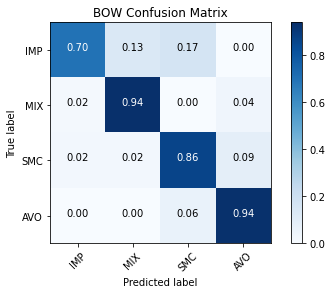

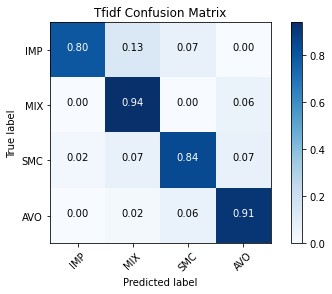

In [36]:
cm1 = confusion_matrix(y_test,predictions1)
plt.figure()

plot_confusion_matrix(cm1, author_info['author'], normalize=True, title='BOW Confusion Matrix')

cm2 = confusion_matrix(y_test,predictions2)
plt.figure()

plot_confusion_matrix(cm2, author_info['author'], normalize=True, title='Tfidf Confusion Matrix')

### v. Light GBM

In [37]:
from lightgbm import LGBMClassifier

text_bow_train_32 = text_bow_train.astype('float32')
text_tfidf_train_32 = text_tfidf_train.astype('float32')
text_bow_test_32 = text_bow_test.astype('float32')
text_tfidf_test_32 = text_tfidf_test.astype('float32')
y_train_32 = y_train.astype('float32')
y_test_32 = y_test.astype('float32')


grid_params = {'max_depth': [2,15,20],
               'num_leaves': [2,5,10]}

gs = GridSearchCV(estimator=LGBMClassifier(random_state=123),
                  param_grid=grid_params,
                  cv=10)

gs.fit(text_bow_train_32, y_train_32)
model1 = gs.best_estimator_
print('1) BOW')
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

gs.fit(text_tfidf_train_32, y_train_32)
model2 = gs.best_estimator_
print('2) Tf-idf')
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

1) BOW
Best Accuracy: 89.26%
Best Params: {'max_depth': 15, 'num_leaves': 10}
2) Tf-idf
Best Accuracy: 88.82%
Best Params: {'max_depth': 15, 'num_leaves': 5}


#### Precision, Recall, F1-score

In [38]:
predictions1 = model1.predict(text_bow_test_32)
print('1) BOW')
display_scores(y_test_32, predictions1)


predictions2 = model2.predict(text_tfidf_test_32)
print('2) Tf-idf')
display_scores(y_test_32, predictions2)

1) BOW
Accuracy: 0.918
Precision: 0.925
Recall: 0.904
F1: 0.911
MCC: 0.891
2) Tf-idf
Accuracy: 0.906
Precision: 0.921
Recall: 0.893
F1: 0.902
MCC: 0.875


#### Confusion matrix

Normalized confusion matrix
[[0.76666667 0.1        0.13333333 0.        ]
 [0.         0.96       0.02       0.02      ]
 [0.02272727 0.02272727 0.95454545 0.        ]
 [0.         0.         0.06382979 0.93617021]]
Normalized confusion matrix
[[0.76666667 0.16666667 0.06666667 0.        ]
 [0.         0.96       0.         0.04      ]
 [0.         0.04545455 0.90909091 0.04545455]
 [0.         0.0212766  0.04255319 0.93617021]]


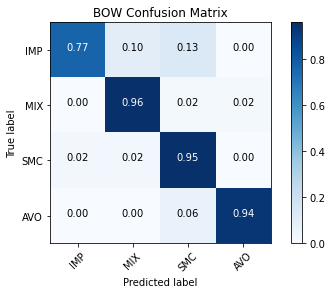

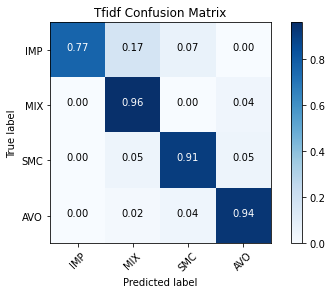

In [39]:
cm1 = confusion_matrix(y_test_32,predictions1)
plt.figure()

plot_confusion_matrix(cm1, author_info['author'], normalize=True, title='BOW Confusion Matrix')

cm2 = confusion_matrix(y_test_32,predictions2)
plt.figure()

plot_confusion_matrix(cm2, author_info['author'], normalize=True, title='Tfidf Confusion Matrix')

## 5) Model evaluation

#### Confidence interval via 0.632+ boostrap on original dataset

In [40]:
bow_transformer = CountVectorizer(tokenizer = LSM_tokenizer).fit(X)

# tfidf_transformer = TfidfVectorizer(tokenizer = LSM_tokenizer).fit(X)

C:\Users\zhan\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [41]:
text_bow = bow_transformer.transform(X)

# text_tfidf = tfidf_transformer.transform(X)

#### Best model: MultinomialNB

In [42]:
from mlxtend.evaluate import bootstrap_point632_score

cv_acc = bootstrap_point632_score(estimator=MultinomialNB(),
                                 X=text_bow,
                                 y=y,
                                 random_seed=123)

print('0.632+ Bootstrap:')
print('Mean Bootstrap score: %.2f%%' % (np.mean(cv_acc)*100))
print('Score Std', np.std(cv_acc))

print('Confidence interval: [%.3f, %.3f]' % (np.percentile(cv_acc, 2.5), np.percentile(cv_acc, 97.5)))

0.632+ Bootstrap:
Mean Bootstrap score: 93.94%
Score Std 0.00906690272971367
Confidence interval: [0.922, 0.957]
